# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

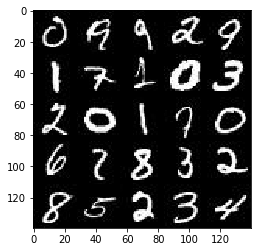

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

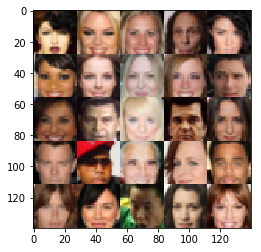

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    image_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='image_real')
    Z_input = tf.placeholder(tf.float32, [None, z_dim], name='Z_input')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return image_real, Z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28*28*channels
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha*x1, x1)
        # Now is 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        # Now is 7x7x128
        
    
        # Flatten
        #flatten = tf.contrib.layers.flatten(relu2)
        flatten = tf.reshape(relu2, (-1, 7*7*128))
        
        # Fully connected layer
        logits = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logits)
        
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*128)
        
        # Reshape
        x2 = tf.reshape(x1, [-1, 7, 7, 128])
        #x2 = tf.contrib.layers.flatten(x2)
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha*bn2, bn2)
        # Now is 7x7x128
        
        x3 = tf.layers.conv2d_transpose(relu2, 64, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha*bn3, bn3)
        # Now is 14*14*64
        
        # Output layer
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same')
        # Now is 28*28*3
        
        output = tf.tanh(logits)
        
        
    return output
        


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
  
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,\
                                                                        labels=tf.ones_like(d_logits_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,\
                                                                        labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,\
                                                                   labels=tf.ones_like(d_logits_fake)))
    
                                 
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    
    losses, samples = [], []
    
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Train Model
                steps += 1
                
                # Multiply 2 change from (-0.5, 0.5) to (-1, 1)
                batch_images = batch_images*2
                
                #Sample radom noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizer, The generator doesn't actually use input_real in g_train_opt
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                
                # Print loss every 10 batches
                if steps % 10==0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append([train_loss_d, train_loss_g])
                 
                # Print samples every 100 batches
                if steps % 100==0:
                    gen_samples = show_generator_output(sess, 50, input_z, image_channels, data_image_mode)
                    samples.append(gen_samples)
        #saver.save(sess, './checkpoints/generator.ckpt')
     
    #     with open('samples.pkl', 'wb') as f:
#         pkl.dump(samples, f)
    
    return losses, samples
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0022... Generator Loss: 0.7937
Epoch 1/2... Discriminator Loss: 0.7616... Generator Loss: 1.3530
Epoch 1/2... Discriminator Loss: 0.8342... Generator Loss: 1.5386
Epoch 1/2... Discriminator Loss: 0.7518... Generator Loss: 1.3806
Epoch 1/2... Discriminator Loss: 0.7749... Generator Loss: 1.8903
Epoch 1/2... Discriminator Loss: 0.9391... Generator Loss: 0.8239
Epoch 1/2... Discriminator Loss: 0.7838... Generator Loss: 2.0552
Epoch 1/2... Discriminator Loss: 0.8242... Generator Loss: 2.2539
Epoch 1/2... Discriminator Loss: 0.7913... Generator Loss: 1.6075
Epoch 1/2... Discriminator Loss: 0.8015... Generator Loss: 1.6900


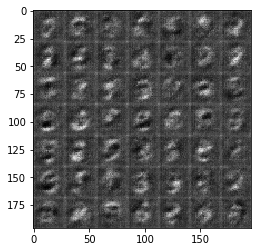

Epoch 1/2... Discriminator Loss: 0.8955... Generator Loss: 1.6158
Epoch 1/2... Discriminator Loss: 1.0897... Generator Loss: 0.7129
Epoch 1/2... Discriminator Loss: 1.4761... Generator Loss: 0.4199
Epoch 1/2... Discriminator Loss: 1.2493... Generator Loss: 0.5832
Epoch 1/2... Discriminator Loss: 1.1244... Generator Loss: 0.6572
Epoch 1/2... Discriminator Loss: 1.0482... Generator Loss: 0.7838
Epoch 1/2... Discriminator Loss: 1.0733... Generator Loss: 0.7884
Epoch 1/2... Discriminator Loss: 1.1443... Generator Loss: 0.6669
Epoch 1/2... Discriminator Loss: 1.0547... Generator Loss: 0.8167
Epoch 1/2... Discriminator Loss: 1.0332... Generator Loss: 0.8496


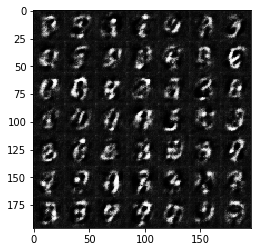

Epoch 1/2... Discriminator Loss: 0.8963... Generator Loss: 1.1859
Epoch 1/2... Discriminator Loss: 0.9710... Generator Loss: 1.4494
Epoch 1/2... Discriminator Loss: 1.0931... Generator Loss: 1.5394
Epoch 1/2... Discriminator Loss: 1.0857... Generator Loss: 1.8361
Epoch 1/2... Discriminator Loss: 0.9958... Generator Loss: 1.6295
Epoch 1/2... Discriminator Loss: 1.0369... Generator Loss: 1.6900
Epoch 1/2... Discriminator Loss: 1.1054... Generator Loss: 1.8115
Epoch 1/2... Discriminator Loss: 1.3765... Generator Loss: 0.4701
Epoch 1/2... Discriminator Loss: 1.1072... Generator Loss: 0.6752
Epoch 1/2... Discriminator Loss: 1.0167... Generator Loss: 0.8195


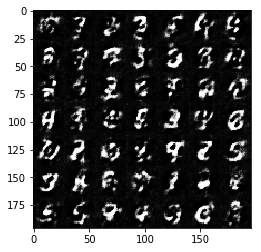

Epoch 1/2... Discriminator Loss: 0.9402... Generator Loss: 1.0911
Epoch 1/2... Discriminator Loss: 0.9922... Generator Loss: 1.5914
Epoch 1/2... Discriminator Loss: 1.1064... Generator Loss: 1.8607
Epoch 1/2... Discriminator Loss: 0.9633... Generator Loss: 1.3258
Epoch 1/2... Discriminator Loss: 1.0039... Generator Loss: 2.0047
Epoch 1/2... Discriminator Loss: 0.9710... Generator Loss: 1.7737
Epoch 1/2... Discriminator Loss: 0.9606... Generator Loss: 1.5783
Epoch 1/2... Discriminator Loss: 1.1110... Generator Loss: 2.0799
Epoch 1/2... Discriminator Loss: 0.9046... Generator Loss: 1.1055
Epoch 1/2... Discriminator Loss: 1.0987... Generator Loss: 0.6983


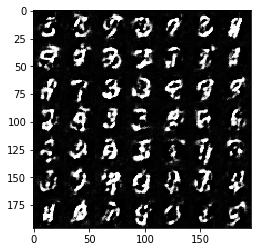

Epoch 1/2... Discriminator Loss: 0.8561... Generator Loss: 1.1700
Epoch 1/2... Discriminator Loss: 1.1150... Generator Loss: 2.1833
Epoch 1/2... Discriminator Loss: 0.8678... Generator Loss: 1.1832
Epoch 1/2... Discriminator Loss: 1.1382... Generator Loss: 0.6544
Epoch 1/2... Discriminator Loss: 0.9195... Generator Loss: 0.9892
Epoch 1/2... Discriminator Loss: 0.9421... Generator Loss: 0.9254
Epoch 1/2... Discriminator Loss: 0.8508... Generator Loss: 1.2137
Epoch 1/2... Discriminator Loss: 0.8612... Generator Loss: 1.5475
Epoch 1/2... Discriminator Loss: 0.9234... Generator Loss: 1.7880
Epoch 1/2... Discriminator Loss: 0.8753... Generator Loss: 1.0974


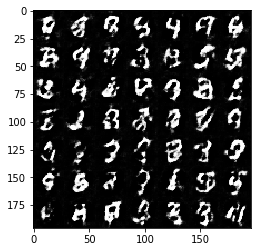

Epoch 1/2... Discriminator Loss: 0.8091... Generator Loss: 1.2640
Epoch 1/2... Discriminator Loss: 0.9776... Generator Loss: 2.2971
Epoch 1/2... Discriminator Loss: 0.9026... Generator Loss: 1.0161
Epoch 1/2... Discriminator Loss: 0.9634... Generator Loss: 2.2907
Epoch 1/2... Discriminator Loss: 0.8627... Generator Loss: 1.7274
Epoch 1/2... Discriminator Loss: 0.8948... Generator Loss: 1.5596
Epoch 1/2... Discriminator Loss: 0.8525... Generator Loss: 1.1182
Epoch 1/2... Discriminator Loss: 0.9001... Generator Loss: 1.6202
Epoch 1/2... Discriminator Loss: 0.8250... Generator Loss: 1.1611
Epoch 1/2... Discriminator Loss: 1.1426... Generator Loss: 0.6457


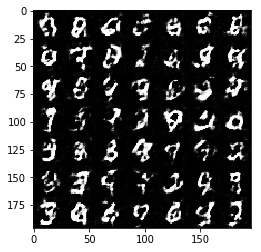

Epoch 1/2... Discriminator Loss: 0.8261... Generator Loss: 1.1300
Epoch 1/2... Discriminator Loss: 0.8695... Generator Loss: 1.0013
Epoch 1/2... Discriminator Loss: 1.0023... Generator Loss: 0.8230
Epoch 1/2... Discriminator Loss: 0.8997... Generator Loss: 1.0799
Epoch 1/2... Discriminator Loss: 0.8202... Generator Loss: 1.3894
Epoch 1/2... Discriminator Loss: 0.9506... Generator Loss: 2.3596
Epoch 1/2... Discriminator Loss: 0.7938... Generator Loss: 1.7122
Epoch 1/2... Discriminator Loss: 1.0650... Generator Loss: 0.7601
Epoch 1/2... Discriminator Loss: 0.9039... Generator Loss: 0.9808
Epoch 1/2... Discriminator Loss: 0.7558... Generator Loss: 1.4846


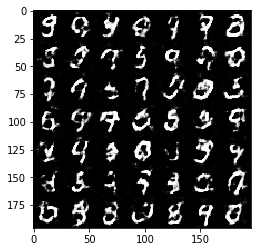

Epoch 1/2... Discriminator Loss: 0.8121... Generator Loss: 1.7920
Epoch 1/2... Discriminator Loss: 0.8222... Generator Loss: 1.6725
Epoch 1/2... Discriminator Loss: 0.9454... Generator Loss: 2.1020
Epoch 1/2... Discriminator Loss: 0.8244... Generator Loss: 1.2158
Epoch 1/2... Discriminator Loss: 0.9064... Generator Loss: 0.9742
Epoch 1/2... Discriminator Loss: 0.9200... Generator Loss: 1.0909
Epoch 1/2... Discriminator Loss: 0.7578... Generator Loss: 1.5804
Epoch 1/2... Discriminator Loss: 0.8917... Generator Loss: 1.2060
Epoch 1/2... Discriminator Loss: 1.0462... Generator Loss: 2.6371
Epoch 1/2... Discriminator Loss: 0.8299... Generator Loss: 1.3635


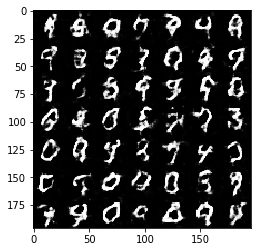

Epoch 1/2... Discriminator Loss: 0.8585... Generator Loss: 1.0366
Epoch 1/2... Discriminator Loss: 0.9814... Generator Loss: 2.2205
Epoch 1/2... Discriminator Loss: 0.9441... Generator Loss: 2.0520
Epoch 1/2... Discriminator Loss: 0.9047... Generator Loss: 1.1265
Epoch 1/2... Discriminator Loss: 0.9719... Generator Loss: 0.9482
Epoch 1/2... Discriminator Loss: 0.9598... Generator Loss: 0.9694
Epoch 1/2... Discriminator Loss: 0.8817... Generator Loss: 1.5792
Epoch 1/2... Discriminator Loss: 0.9292... Generator Loss: 1.9518
Epoch 1/2... Discriminator Loss: 1.0179... Generator Loss: 1.8259
Epoch 1/2... Discriminator Loss: 0.9151... Generator Loss: 1.2562


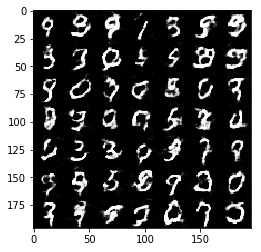

Epoch 1/2... Discriminator Loss: 1.0116... Generator Loss: 2.0610
Epoch 1/2... Discriminator Loss: 1.0075... Generator Loss: 2.2256
Epoch 1/2... Discriminator Loss: 1.0137... Generator Loss: 1.6729
Epoch 2/2... Discriminator Loss: 0.8501... Generator Loss: 1.5581
Epoch 2/2... Discriminator Loss: 0.9576... Generator Loss: 1.7822
Epoch 2/2... Discriminator Loss: 1.0330... Generator Loss: 1.8950
Epoch 2/2... Discriminator Loss: 1.0426... Generator Loss: 0.7654
Epoch 2/2... Discriminator Loss: 0.9911... Generator Loss: 0.8562
Epoch 2/2... Discriminator Loss: 1.0405... Generator Loss: 0.7882
Epoch 2/2... Discriminator Loss: 1.1565... Generator Loss: 0.6671


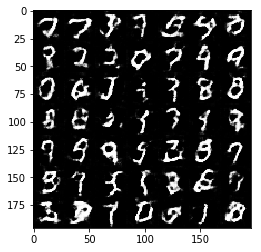

Epoch 2/2... Discriminator Loss: 0.9847... Generator Loss: 0.8617
Epoch 2/2... Discriminator Loss: 1.0217... Generator Loss: 0.8302
Epoch 2/2... Discriminator Loss: 1.0467... Generator Loss: 1.6347
Epoch 2/2... Discriminator Loss: 0.9622... Generator Loss: 1.9619
Epoch 2/2... Discriminator Loss: 0.8869... Generator Loss: 1.4202
Epoch 2/2... Discriminator Loss: 1.0565... Generator Loss: 0.7875
Epoch 2/2... Discriminator Loss: 1.5230... Generator Loss: 0.4211
Epoch 2/2... Discriminator Loss: 0.9328... Generator Loss: 1.0655
Epoch 2/2... Discriminator Loss: 0.8595... Generator Loss: 1.2043
Epoch 2/2... Discriminator Loss: 0.9818... Generator Loss: 1.5662


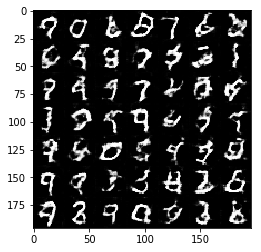

Epoch 2/2... Discriminator Loss: 0.9151... Generator Loss: 1.5503
Epoch 2/2... Discriminator Loss: 1.0794... Generator Loss: 1.7783
Epoch 2/2... Discriminator Loss: 0.9706... Generator Loss: 1.3333
Epoch 2/2... Discriminator Loss: 0.9454... Generator Loss: 0.9646
Epoch 2/2... Discriminator Loss: 1.0836... Generator Loss: 0.7215
Epoch 2/2... Discriminator Loss: 0.9880... Generator Loss: 0.8397
Epoch 2/2... Discriminator Loss: 1.0130... Generator Loss: 1.3654
Epoch 2/2... Discriminator Loss: 0.9577... Generator Loss: 1.1269
Epoch 2/2... Discriminator Loss: 1.0680... Generator Loss: 0.7565
Epoch 2/2... Discriminator Loss: 0.9940... Generator Loss: 0.9345


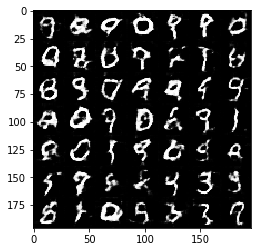

Epoch 2/2... Discriminator Loss: 0.9188... Generator Loss: 1.1562
Epoch 2/2... Discriminator Loss: 0.9611... Generator Loss: 1.2807
Epoch 2/2... Discriminator Loss: 0.9693... Generator Loss: 1.0311
Epoch 2/2... Discriminator Loss: 0.9636... Generator Loss: 1.1213
Epoch 2/2... Discriminator Loss: 0.9524... Generator Loss: 1.4243
Epoch 2/2... Discriminator Loss: 1.2563... Generator Loss: 0.6484
Epoch 2/2... Discriminator Loss: 1.0096... Generator Loss: 1.0599
Epoch 2/2... Discriminator Loss: 1.0707... Generator Loss: 0.7619
Epoch 2/2... Discriminator Loss: 0.8888... Generator Loss: 1.3743
Epoch 2/2... Discriminator Loss: 0.9101... Generator Loss: 1.3345


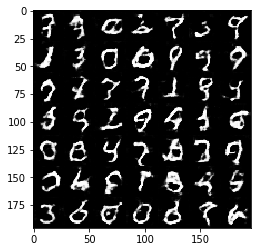

Epoch 2/2... Discriminator Loss: 0.9175... Generator Loss: 1.0203
Epoch 2/2... Discriminator Loss: 1.9189... Generator Loss: 0.3060
Epoch 2/2... Discriminator Loss: 1.0217... Generator Loss: 0.9343
Epoch 2/2... Discriminator Loss: 1.0149... Generator Loss: 0.8376
Epoch 2/2... Discriminator Loss: 0.9457... Generator Loss: 1.1176
Epoch 2/2... Discriminator Loss: 0.8791... Generator Loss: 1.2933
Epoch 2/2... Discriminator Loss: 0.9323... Generator Loss: 1.2274
Epoch 2/2... Discriminator Loss: 1.0929... Generator Loss: 1.6189
Epoch 2/2... Discriminator Loss: 0.9307... Generator Loss: 1.1003
Epoch 2/2... Discriminator Loss: 0.9470... Generator Loss: 1.5540


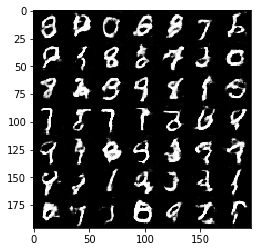

Epoch 2/2... Discriminator Loss: 0.9588... Generator Loss: 1.2220
Epoch 2/2... Discriminator Loss: 1.0796... Generator Loss: 1.9030
Epoch 2/2... Discriminator Loss: 0.9537... Generator Loss: 1.6908
Epoch 2/2... Discriminator Loss: 0.9089... Generator Loss: 1.2414
Epoch 2/2... Discriminator Loss: 1.0018... Generator Loss: 0.8693
Epoch 2/2... Discriminator Loss: 1.0807... Generator Loss: 0.7498
Epoch 2/2... Discriminator Loss: 0.9692... Generator Loss: 0.9439
Epoch 2/2... Discriminator Loss: 1.5640... Generator Loss: 0.4285
Epoch 2/2... Discriminator Loss: 1.0000... Generator Loss: 1.0825
Epoch 2/2... Discriminator Loss: 0.9545... Generator Loss: 1.0819


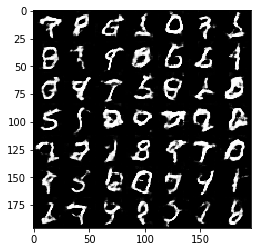

Epoch 2/2... Discriminator Loss: 1.2305... Generator Loss: 0.6195
Epoch 2/2... Discriminator Loss: 1.0320... Generator Loss: 0.8270
Epoch 2/2... Discriminator Loss: 0.9276... Generator Loss: 1.4387
Epoch 2/2... Discriminator Loss: 0.8599... Generator Loss: 1.4291
Epoch 2/2... Discriminator Loss: 0.9671... Generator Loss: 0.8847
Epoch 2/2... Discriminator Loss: 0.9786... Generator Loss: 1.0295
Epoch 2/2... Discriminator Loss: 0.9458... Generator Loss: 1.1370
Epoch 2/2... Discriminator Loss: 0.8989... Generator Loss: 1.3036
Epoch 2/2... Discriminator Loss: 0.8584... Generator Loss: 1.2668
Epoch 2/2... Discriminator Loss: 0.9397... Generator Loss: 1.0115


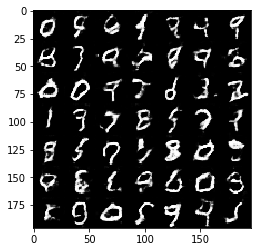

Epoch 2/2... Discriminator Loss: 0.9120... Generator Loss: 1.0176
Epoch 2/2... Discriminator Loss: 0.9795... Generator Loss: 2.1553
Epoch 2/2... Discriminator Loss: 0.8366... Generator Loss: 1.5002
Epoch 2/2... Discriminator Loss: 0.8800... Generator Loss: 1.0846
Epoch 2/2... Discriminator Loss: 0.9237... Generator Loss: 0.9809
Epoch 2/2... Discriminator Loss: 1.2967... Generator Loss: 0.5397
Epoch 2/2... Discriminator Loss: 0.8945... Generator Loss: 1.4011
Epoch 2/2... Discriminator Loss: 0.8693... Generator Loss: 1.4467
Epoch 2/2... Discriminator Loss: 0.9264... Generator Loss: 1.2383
Epoch 2/2... Discriminator Loss: 0.8369... Generator Loss: 1.3858


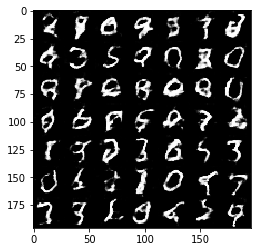

Epoch 2/2... Discriminator Loss: 0.8733... Generator Loss: 1.3245
Epoch 2/2... Discriminator Loss: 1.1423... Generator Loss: 1.9303
Epoch 2/2... Discriminator Loss: 1.0129... Generator Loss: 0.9683
Epoch 2/2... Discriminator Loss: 1.0185... Generator Loss: 1.6534
Epoch 2/2... Discriminator Loss: 0.9795... Generator Loss: 0.8609
Epoch 2/2... Discriminator Loss: 0.9028... Generator Loss: 1.1691
Epoch 2/2... Discriminator Loss: 2.2832... Generator Loss: 0.1985
Epoch 2/2... Discriminator Loss: 0.9017... Generator Loss: 1.1459
Epoch 2/2... Discriminator Loss: 0.9077... Generator Loss: 1.1520
Epoch 2/2... Discriminator Loss: 0.9648... Generator Loss: 1.0398


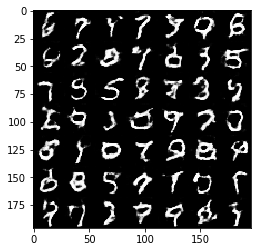

Epoch 2/2... Discriminator Loss: 0.8692... Generator Loss: 1.6979
Epoch 2/2... Discriminator Loss: 1.0169... Generator Loss: 0.8351
Epoch 2/2... Discriminator Loss: 0.9696... Generator Loss: 0.8716
Epoch 2/2... Discriminator Loss: 0.8802... Generator Loss: 1.4477
Epoch 2/2... Discriminator Loss: 0.9683... Generator Loss: 1.7012
Epoch 2/2... Discriminator Loss: 0.8699... Generator Loss: 1.1025
Epoch 2/2... Discriminator Loss: 0.9850... Generator Loss: 0.9143


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2
tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1420... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 0.7547... Generator Loss: 1.3209
Epoch 1/1... Discriminator Loss: 0.6625... Generator Loss: 1.6163
Epoch 1/1... Discriminator Loss: 0.5520... Generator Loss: 2.1050
Epoch 1/1... Discriminator Loss: 0.4744... Generator Loss: 2.7027
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 0.5973... Generator Loss: 2.5395
Epoch 1/1... Discriminator Loss: 0.8228... Generator Loss: 2.3024
Epoch 1/1... Discriminator Loss: 0.9158... Generator Loss: 1.8937
Epoch 1/1... Discriminator Loss: 0.8628... Generator Loss: 1.6707


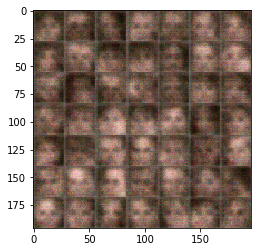

Epoch 1/1... Discriminator Loss: 0.8449... Generator Loss: 1.3735
Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 1.0262
Epoch 1/1... Discriminator Loss: 0.9021... Generator Loss: 1.0336
Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 0.8220... Generator Loss: 2.1087
Epoch 1/1... Discriminator Loss: 0.8879... Generator Loss: 1.3758
Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 0.8882... Generator Loss: 1.1689
Epoch 1/1... Discriminator Loss: 0.8414... Generator Loss: 1.2808
Epoch 1/1... Discriminator Loss: 0.8196... Generator Loss: 1.2025


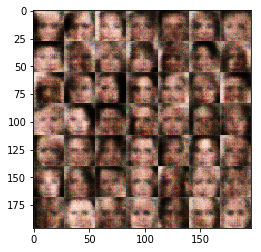

Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 0.8256... Generator Loss: 1.9176
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.5538
Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 0.9655... Generator Loss: 1.3197
Epoch 1/1... Discriminator Loss: 1.0965... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.5516... Generator Loss: 0.4392
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.5745
Epoch 1/1... Discriminator Loss: 1.2144... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 0.9579... Generator Loss: 1.5381


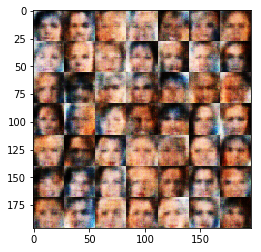

Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 1.3677
Epoch 1/1... Discriminator Loss: 1.0654... Generator Loss: 1.6618
Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 1.1965
Epoch 1/1... Discriminator Loss: 1.1533... Generator Loss: 2.0863
Epoch 1/1... Discriminator Loss: 0.7881... Generator Loss: 1.8529
Epoch 1/1... Discriminator Loss: 0.9232... Generator Loss: 1.7372
Epoch 1/1... Discriminator Loss: 0.9334... Generator Loss: 1.1969
Epoch 1/1... Discriminator Loss: 0.8929... Generator Loss: 1.7713
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 2.2435
Epoch 1/1... Discriminator Loss: 0.9601... Generator Loss: 0.9719


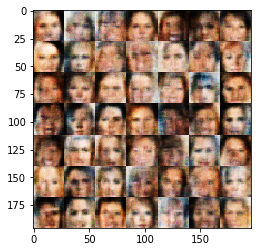

Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 2.1378
Epoch 1/1... Discriminator Loss: 0.8895... Generator Loss: 1.6720
Epoch 1/1... Discriminator Loss: 0.8861... Generator Loss: 1.0929
Epoch 1/1... Discriminator Loss: 1.0233... Generator Loss: 0.8426
Epoch 1/1... Discriminator Loss: 0.9267... Generator Loss: 1.3057
Epoch 1/1... Discriminator Loss: 0.8315... Generator Loss: 1.5209
Epoch 1/1... Discriminator Loss: 1.0136... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 0.9416... Generator Loss: 1.6528
Epoch 1/1... Discriminator Loss: 0.9542... Generator Loss: 1.7013
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.5345


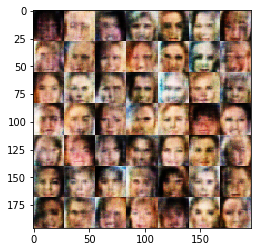

Epoch 1/1... Discriminator Loss: 1.0058... Generator Loss: 0.9016
Epoch 1/1... Discriminator Loss: 0.7360... Generator Loss: 1.5021
Epoch 1/1... Discriminator Loss: 0.9794... Generator Loss: 1.1718
Epoch 1/1... Discriminator Loss: 1.0401... Generator Loss: 1.7521
Epoch 1/1... Discriminator Loss: 0.8942... Generator Loss: 1.1420
Epoch 1/1... Discriminator Loss: 0.8424... Generator Loss: 1.2237
Epoch 1/1... Discriminator Loss: 0.8360... Generator Loss: 1.6221
Epoch 1/1... Discriminator Loss: 2.4167... Generator Loss: 3.3368
Epoch 1/1... Discriminator Loss: 0.9800... Generator Loss: 1.0145
Epoch 1/1... Discriminator Loss: 0.8045... Generator Loss: 1.3744


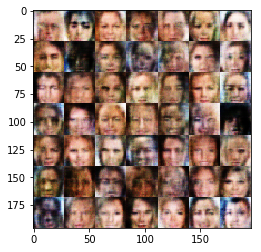

Epoch 1/1... Discriminator Loss: 0.8759... Generator Loss: 1.2580
Epoch 1/1... Discriminator Loss: 0.8745... Generator Loss: 1.1803
Epoch 1/1... Discriminator Loss: 1.0996... Generator Loss: 1.8570
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 1.7577
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.8767
Epoch 1/1... Discriminator Loss: 1.0225... Generator Loss: 1.3552
Epoch 1/1... Discriminator Loss: 0.9260... Generator Loss: 1.1240
Epoch 1/1... Discriminator Loss: 0.9507... Generator Loss: 1.3013
Epoch 1/1... Discriminator Loss: 0.8780... Generator Loss: 1.2874
Epoch 1/1... Discriminator Loss: 1.0105... Generator Loss: 1.1698


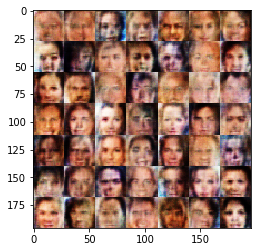

Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.5360
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 0.9277... Generator Loss: 1.1249
Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 0.9203
Epoch 1/1... Discriminator Loss: 0.9821... Generator Loss: 1.0911
Epoch 1/1... Discriminator Loss: 0.8745... Generator Loss: 1.1095
Epoch 1/1... Discriminator Loss: 0.9639... Generator Loss: 1.1242
Epoch 1/1... Discriminator Loss: 1.0012... Generator Loss: 1.5389
Epoch 1/1... Discriminator Loss: 1.0269... Generator Loss: 0.9443
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.6988


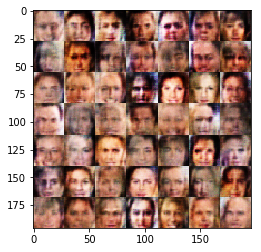

Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.1079... Generator Loss: 0.9581
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.0836... Generator Loss: 1.4296
Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 0.8681
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 0.8817


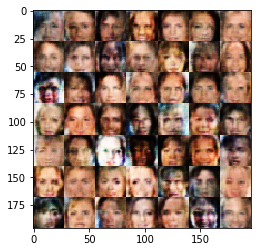

Epoch 1/1... Discriminator Loss: 1.0583... Generator Loss: 1.0824
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 1.1886
Epoch 1/1... Discriminator Loss: 1.0876... Generator Loss: 0.9999
Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 1.0234
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 0.9557
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 1.2625
Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 0.9887
Epoch 1/1... Discriminator Loss: 1.1395... Generator Loss: 1.0859
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.8495


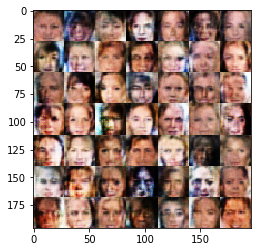

Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 1.0523
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 1.2718
Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 1.3496
Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 0.8535
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 1.5729
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 0.6988


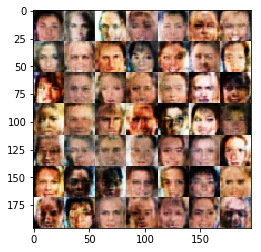

Epoch 1/1... Discriminator Loss: 1.2588... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.0803... Generator Loss: 0.9600
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 1.0315
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 0.9557
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 1.7472
Epoch 1/1... Discriminator Loss: 1.0765... Generator Loss: 1.0880
Epoch 1/1... Discriminator Loss: 1.1296... Generator Loss: 0.9419
Epoch 1/1... Discriminator Loss: 1.1426... Generator Loss: 1.0559


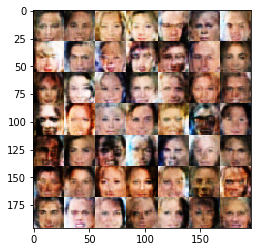

Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.4950
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 1.1108
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.1832... Generator Loss: 1.3744
Epoch 1/1... Discriminator Loss: 1.1379... Generator Loss: 1.0895
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 0.9276
Epoch 1/1... Discriminator Loss: 1.1853... Generator Loss: 0.9164
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.5914
Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 0.9156


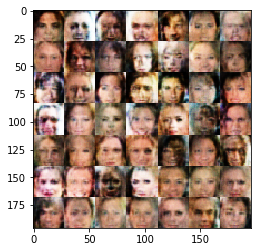

Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 1.0747
Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 0.8131
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 0.9689... Generator Loss: 1.0404
Epoch 1/1... Discriminator Loss: 1.0811... Generator Loss: 1.1223
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 1.5991
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.4788
Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 1.0237
Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 1.3251


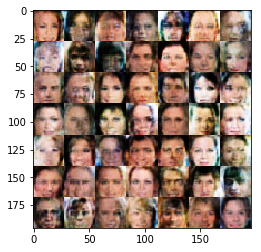

Epoch 1/1... Discriminator Loss: 1.1470... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 1.5157
Epoch 1/1... Discriminator Loss: 1.2338... Generator Loss: 1.2566
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 1.5031
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.9049
Epoch 1/1... Discriminator Loss: 1.1034... Generator Loss: 1.3275
Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 1.0891
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 1.4449
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 0.9441


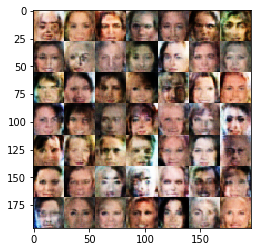

Epoch 1/1... Discriminator Loss: 1.1442... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 0.9507
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 0.9150
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 1.0340
Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 1.0076
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 1.7709
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 1.0969
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 1.5374


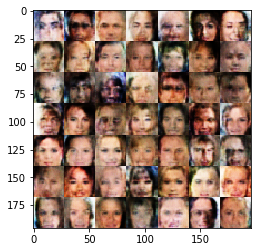

Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 1.0966
Epoch 1/1... Discriminator Loss: 1.0274... Generator Loss: 1.5118
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 1.3099
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 1.1250
Epoch 1/1... Discriminator Loss: 1.1349... Generator Loss: 1.2483
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 1.4883
Epoch 1/1... Discriminator Loss: 0.9935... Generator Loss: 1.0375
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 0.8898


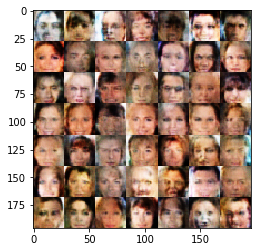

Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 1.0825
Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 1.2755
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.5534
Epoch 1/1... Discriminator Loss: 1.2455... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.6439


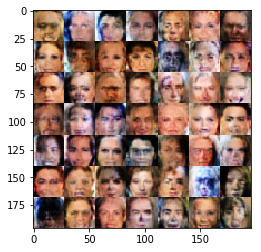

Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 1.1857
Epoch 1/1... Discriminator Loss: 0.9580... Generator Loss: 1.0789
Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 1.1188
Epoch 1/1... Discriminator Loss: 1.0865... Generator Loss: 0.9931
Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 1.7531
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 0.9241
Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 1.5167
Epoch 1/1... Discriminator Loss: 0.9759... Generator Loss: 1.0189


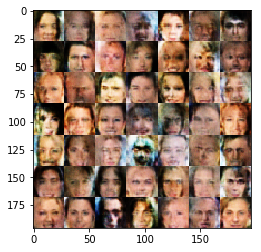

Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 1.7219
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 0.8374
Epoch 1/1... Discriminator Loss: 0.9870... Generator Loss: 0.8752
Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 0.6712
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 1.3769
Epoch 1/1... Discriminator Loss: 1.1009... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.5245... Generator Loss: 0.4246
Epoch 1/1... Discriminator Loss: 1.1173... Generator Loss: 0.8560


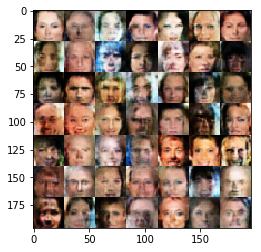

Epoch 1/1... Discriminator Loss: 1.1510... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.0607... Generator Loss: 1.4279
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 1.3618
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 1.1025
Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 0.9766
Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 1.2828
Epoch 1/1... Discriminator Loss: 1.5105... Generator Loss: 1.9661
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 1.0277
Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 0.9935


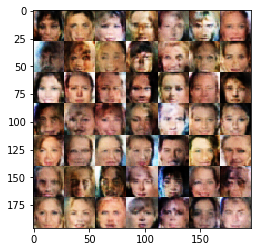

Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 0.8491
Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.0720... Generator Loss: 1.2568
Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 1.4925
Epoch 1/1... Discriminator Loss: 1.1430... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.1225... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 0.9229... Generator Loss: 1.6143
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.9337
Epoch 1/1... Discriminator Loss: 1.0469... Generator Loss: 1.4725


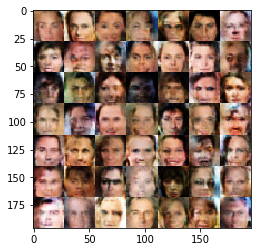

Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.5841
Epoch 1/1... Discriminator Loss: 0.9024... Generator Loss: 1.0966
Epoch 1/1... Discriminator Loss: 1.1431... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.1849... Generator Loss: 1.5334
Epoch 1/1... Discriminator Loss: 1.4796... Generator Loss: 2.0237
Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 0.8820
Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.2318... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 0.9348... Generator Loss: 1.1868
Epoch 1/1... Discriminator Loss: 1.1853... Generator Loss: 1.4941


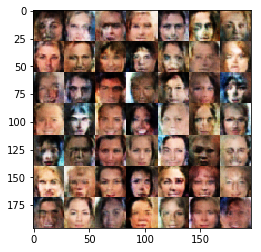

Epoch 1/1... Discriminator Loss: 1.1336... Generator Loss: 1.0496
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 0.8490
Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 0.9083
Epoch 1/1... Discriminator Loss: 1.1648... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.5241
Epoch 1/1... Discriminator Loss: 1.1768... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.4808... Generator Loss: 1.7217
Epoch 1/1... Discriminator Loss: 1.5473... Generator Loss: 1.7384


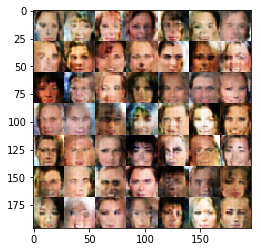

Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 1.0223
Epoch 1/1... Discriminator Loss: 1.0365... Generator Loss: 1.1306
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 0.8684
Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 0.8904
Epoch 1/1... Discriminator Loss: 1.1755... Generator Loss: 1.0326
Epoch 1/1... Discriminator Loss: 1.1203... Generator Loss: 1.1548
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 0.8086


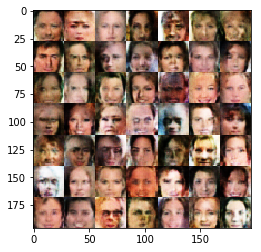

Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 1.5037
Epoch 1/1... Discriminator Loss: 1.0471... Generator Loss: 0.9430
Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 0.6078
Epoch 1/1... Discriminator Loss: 1.0261... Generator Loss: 1.1368
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.6132
Epoch 1/1... Discriminator Loss: 0.9736... Generator Loss: 1.3799
Epoch 1/1... Discriminator Loss: 1.6851... Generator Loss: 2.1280
Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 0.9203
Epoch 1/1... Discriminator Loss: 1.1707... Generator Loss: 0.9253
Epoch 1/1... Discriminator Loss: 1.0607... Generator Loss: 1.1636


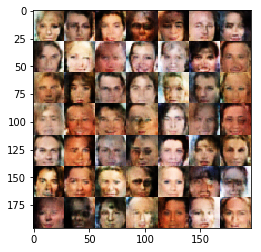

Epoch 1/1... Discriminator Loss: 1.1907... Generator Loss: 0.8993
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 1.0771
Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 1.0036
Epoch 1/1... Discriminator Loss: 1.0940... Generator Loss: 1.2379
Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.0178... Generator Loss: 0.9337
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 1.1935
Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 0.9738
Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 1.6405
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.4823


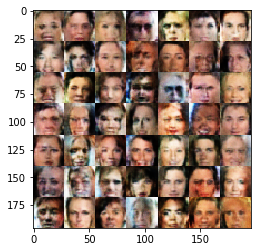

Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 1.1441
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 1.6504
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 1.5554
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.5892
Epoch 1/1... Discriminator Loss: 1.0352... Generator Loss: 1.0752
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 0.5896
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.5137
Epoch 1/1... Discriminator Loss: 0.9774... Generator Loss: 1.1275
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.4966


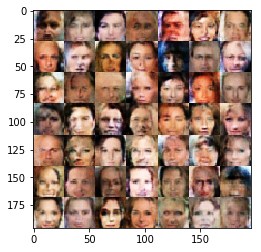

Epoch 1/1... Discriminator Loss: 1.1316... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 1.0955
Epoch 1/1... Discriminator Loss: 0.9302... Generator Loss: 1.1036
Epoch 1/1... Discriminator Loss: 1.6159... Generator Loss: 2.0731
Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 1.2257
Epoch 1/1... Discriminator Loss: 0.8513... Generator Loss: 1.2455
Epoch 1/1... Discriminator Loss: 1.0008... Generator Loss: 1.2351
Epoch 1/1... Discriminator Loss: 1.5592... Generator Loss: 0.4329


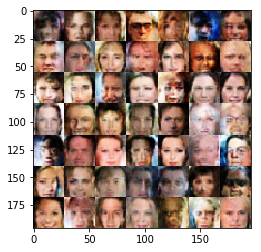

Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 0.6272
Epoch 1/1... Discriminator Loss: 0.8989... Generator Loss: 1.3096
Epoch 1/1... Discriminator Loss: 1.1029... Generator Loss: 1.3451
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.5612
Epoch 1/1... Discriminator Loss: 1.0057... Generator Loss: 1.3261
Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 1.0906
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.5975
Epoch 1/1... Discriminator Loss: 0.9926... Generator Loss: 1.1892
Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 1.1551


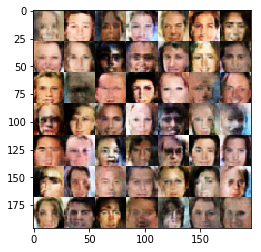

Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 0.8563... Generator Loss: 1.1605
Epoch 1/1... Discriminator Loss: 2.2666... Generator Loss: 0.2157
Epoch 1/1... Discriminator Loss: 1.0995... Generator Loss: 0.8855
Epoch 1/1... Discriminator Loss: 1.0912... Generator Loss: 1.2459
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 0.9804... Generator Loss: 1.1071
Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 1.5664
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.6044
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 0.8827


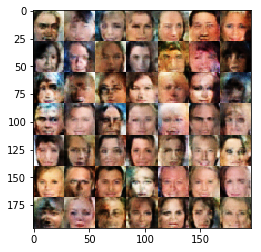

Epoch 1/1... Discriminator Loss: 0.8805... Generator Loss: 1.2394
Epoch 1/1... Discriminator Loss: 0.9049... Generator Loss: 1.4671
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 1.0224
Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 0.8747
Epoch 1/1... Discriminator Loss: 0.9882... Generator Loss: 1.0692
Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 1.3496


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2

# Avoid stacking memory
tf.reset_default_graph()


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.